In [1]:
from sklearn.cluster import KMeans
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score
import math

from keras import Model
from keras.layers import LSTM, Input, Dense, Concatenate, Embedding, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
print(tf.config.list_physical_devices('GPU'))


Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Constants


In [2]:
batch_size = 100
debug  =0

In [18]:

# train=600000
df_for_training = pd.read_csv('result_ii.txt', usecols=[0, 1, 2],nrows=1000000)#reading only PC and Delta
cols = df_for_training.columns
df_for_training = df_for_training[cols].astype(float)
cols = df_for_training.columns

print(df_for_training.shape)

vocab_deltas = pd.read_csv("vocab_deltas.txt", dtype=np.int32,nrows=2000)
vocab_deltas = vocab_deltas['top_deltas'].tolist()

print("vocab_deltas is of type",type(vocab_deltas[0]))
print("Vocab size is: ", len(vocab_deltas))
vocab_size = len(vocab_deltas)

MAX_DELTA = int(df_for_training['Delta'].nunique()) + 1
MAX_PC = int(df_for_training['PC'].nunique()) + 1


oe_PC = OrdinalEncoder()
oe_Delta = OrdinalEncoder()

oe_PC = oe_PC.fit(df_for_training['PC'].values.reshape(-1, 1))
oe_Delta = oe_Delta.fit(df_for_training['Delta'].values.reshape(-1, 1))


from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
ohe.fit(np.array(vocab_deltas).reshape(-1,1))

(100000, 3)
vocab_deltas is of type <class 'int'>
Vocab size is:  2


OneHotEncoder(handle_unknown='ignore', sparse=False)

In [19]:
from tensorflow.python.keras.utils import data_utils


class CustomDataGen(data_utils.Sequence):
    
    def __init__(self, df, batch_size, ohe, oe_pc, oe_delta):
        self.df = df.copy()
        self.n_future = 1
        self.n_past = 20
        self.batch_size = batch_size
        self.n = len(self.df) - self.n_past  ##calculate it precisely
        self.n = math.ceil(self.n // self.batch_size)
        self.n -=1
        self.ohe = ohe
        self.ix = 0
        self.ohe = ohe
        self.tmp_y = self.df['Delta'].copy().to_numpy()
        self.oe_pc = oe_pc
        self.oe_delta = oe_delta

        self.df['PC'] = self.oe_pc.transform(self.df['PC'].values.reshape(-1, 1))
        self.df['Delta'] = self.oe_delta.transform(self.df['Delta'].values.reshape(-1, 1))
        # print(self.df.head())
        self.df = self.df.to_numpy(dtype=np.float64)
        self.iterator_index = 0
        # print(self.df[0])

    def __next__(self):
        data = self.__getitem__(self.ix)
        self.ix  += 1
        self.ix %= self.n
        return data
    
    def __iter__(self):
        while True:
            data= self.__getitem__(self.iterator_index)
            self.iterator_index += 1
            self.iterator_index %= self.n
            yield data
    def reset_iterator(self):
        self.iterator_index = 0
    
    def __getitem__(self, index):
        global debug
        """
        index is batch_index
        each batch will have batch_size elements
        """
        index %= self.n
        X = []
        Y = []
        start = index * self.batch_size
        for i in range(start, start+batch_size):
            X.append(self.df[i:i + self.n_past, 1:])
            Y.append(self.ohe.transform(np.array(self.tmp_y[i + self.n_past : i + self.n_past + 1]).
                                        reshape(-1,1)))
            
        X = np.array(X)
        Y = np.array(Y)
        shp = Y.shape
        Y = Y.reshape(shp[0], shp[2])
        
        
        tmp = np.split(X, 2, axis=2)
        tmp[0] = tmp[0].reshape((batch_size, 20))
        tmp[1] = tmp[1].reshape((batch_size, 20))
        if (debug == 1 and index == 0):
          print(tmp, y)
        return (tmp, Y)

    def getdatapoint(self, i):
        return self.df[i:i+self.n_past, :]
    
    def __len__(self):
        return self.n

In [7]:
print(df_for_training.shape)

(10000, 3)


In [20]:

df_train, df_test = train_test_split(df_for_training, test_size = 0.25, shuffle=False)
df_train, df_validate = train_test_split(df_train, test_size = 0.20, shuffle=False)

# df_test['PC'] = oe_PC.transform(df_test['PC'].values.reshape(-1, 1))

# df_all = CustomDataGen(df_for_training, batch_size, ohe, oe_PC, oe_Delta)
data_gen_train = CustomDataGen(df_train, batch_size, ohe, oe_PC, oe_Delta)
data_gen_validate = CustomDataGen(df_validate, batch_size, ohe, oe_PC, oe_Delta)
data_gen_test = CustomDataGen(df_test, batch_size, ohe, oe_PC, oe_Delta)



In [21]:
EMBEDDING_SIZE = 10
n_past=20
PC_INP = Input(shape=(n_past,), name="input_1")
PC_EMB = Embedding(MAX_PC+1, EMBEDDING_SIZE, input_length=n_past)(PC_INP)

DELTA_INP = Input(shape=(n_past,), name="input_2")
DELTA_EMB = Embedding(MAX_DELTA+1, EMBEDDING_SIZE,input_length=n_past)(DELTA_INP)


CONCATENATED_EMB = Concatenate(axis=1)([PC_EMB, DELTA_EMB])

LSTM_1 = LSTM(128, activation = 'sigmoid', return_sequences=True)(CONCATENATED_EMB)
LSTM_2 = LSTM(128, activation='sigmoid', return_sequences=False)(LSTM_1)
OP_LAYER = Dense(vocab_size, activation='sigmoid')(LSTM_2)

model = Model(inputs=[PC_INP, DELTA_INP], outputs=[OP_LAYER])
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 10)       3920        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 20, 10)       170         input_2[0][0]                    
____________________________________________________________________________________________

In [22]:
metric="val_loss"
es = EarlyStopping(monitor=metric, mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

In [23]:
history = model.fit(data_gen_train, steps_per_epoch = data_gen_train.__len__(),
                    validation_data=data_gen_validate ,validation_steps=data_gen_validate.__len__(),
                    epochs=2,callbacks=[es, mc],shuffle=False)



/home/me/anaconda3/envs/menv/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
598/598 [==============================] - 38s 64ms/step - loss: 0.0464 - accuracy: 0.9800 - val_loss: 2.8471e-04 - val_accuracy: 0.9995

Epoch 00001: val_loss improved from inf to 0.00028, saving model to best_model.h5
Epoch 2/2
598/598 [==============================] - 38s 64ms/step - loss: 0.0502 - accuracy: 0.9882 - val_loss: 0.0012 - val_accuracy: 0.9995

Epoch 00002: val_loss did not improve from 0.00028


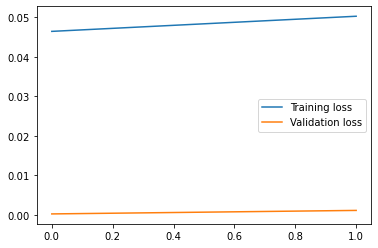

In [24]:


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [25]:

saved_model = load_model('best_model.h5')
data_gen_test.reset_iterator()
Y_predict = saved_model.predict(data_gen_test,
                                steps=data_gen_test.__len__(),  verbose=1)
# data_gen_test.reset_iterator()
train_loss = saved_model.evaluate(data_gen_test,
                                      steps=data_gen_test.__len__(),  verbose=1)
print(train_loss)
print(Y_predict.shape)
print(type(Y_predict))
print(Y_predict.dtype)

/home/me/anaconda3/envs/menv/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


248/248 [==============================] - 6s 25ms/step
[0.0002847122959792614, 1.0]
(24800, 2)
<class 'numpy.ndarray'>
float32


In [53]:
print(Y_predict.shape)
print(Y_predict)
y_new = Y_predict.argmax(1)
print(y_new.shape)
pred_addr_list = []

# print(df_test.head())
df_new_t = list(df_test['Cache'])

for i in range(len(y_new)):
    pred_addr_list.append((df_new_t[i], vocab_deltas[y_new[i]]))


# print(str(pred_addr_list[i]))
f = open("pred_save.txt", "w")


for x in pred_addr_list:
    f.write(str(pred_addr_list[i]))
f.close()

(24800, 2)
[[2.7765904e-04 9.7492695e-01]
 [2.7765852e-04 9.7492695e-01]
 [2.7765852e-04 9.7492695e-01]
 ...
 [2.7765852e-04 9.7492695e-01]
 [2.7765852e-04 9.7492695e-01]
 [2.7765852e-04 9.7492695e-01]]
[1 1 1 ... 1 1 1]
(24800,)
76725248.0


In [ ]:
sub_total = []
print( data_gen_test.n)
for j in range(0, data_gen_test.n):
    _, y = data_gen_test.__getitem__(j)
    sub_total.append(y)
print(type(sub_total[0]))
Y_true = np.concatenate(sub_total, axis = 0)
print(Y_true.shape)


2498
<class 'numpy.ndarray'>
(249800, 500)


In [ ]:
print(Y_true)

In [ ]:


from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


    

Y_test_comp = Y_true.argmax(axis=1)
Y_predict_comp = Y_predict.argmax(axis=1)
Y_predict_comp = Y_predict_comp[0:len(Y_test_comp)]

arr = confusion_matrix(Y_test_comp, Y_predict_comp)
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test_comp, Y_predict_comp)))
print('Weighted Precision: {:.2f}'.format(precision_score(Y_test_comp, Y_predict_comp, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test_comp, Y_predict_comp, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test_comp, Y_predict_comp, average='weighted')))
print("#############################################")



Accuracy: 0.07
Weighted Precision: 0.00
Weighted Recall: 0.07
Weighted F1-score: 0.01
#############################################


/home/vijay/anaconda3/envs/ayushenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tmp_y = df_test['Delta'].copy()

df_test['PC'] = oe_PC.transform(df_test['PC'].values.reshape(-1, 1))
df_test['Delta'] = oe_Delta.transform(df_test['Delta'].values.reshape(-1, 1))

testX = []
testY = []
n_past =20
n_future = 1

for i in range(n_past, len(df_test) - n_future +1):
    testX.append(df_test.iloc[i - n_past:i, :])#include pc and delta
    testY.append(ohe.transform(np.array(tmp_y[i + n_future - 1:i + n_future]).reshape(-1, 1)))
testX = np.array(testX)
testY = np.array(testY)



<ipython-input-11-fc71fa543719>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['PC'] = oe_PC.transform(df_test['PC'].values.reshape(-1, 1))
<ipython-input-11-fc71fa543719>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Delta'] = oe_Delta.transform(df_test['Delta'].values.reshape(-1, 1))


In [ ]:
shp = testY.shape
testY = testY.reshape(shp[0], shp[2])

In [ ]:
saved_model = load_model('best_model.h5')
train_loss = saved_model.evaluate(np.split(testX, 2, axis=2), testY, verbose=1)
Y_predict = saved_model.predict(np.split(testX, 2, axis=2))
print(train_loss)

7812/7812 [==============================] - 123s 16ms/step - loss: 0.9413 - accuracy: 0.7287
